In [2]:
%pip install pandas numpy matplotlib seaborn torch scikit-learn transformers optuna

  Using cached pandas-2.2.3-cp312-cp312-macosx_11_0_arm64.whl.metadata (89 kB)
  Using cached numpy-2.1.2-cp312-cp312-macosx_14_0_arm64.whl.metadata (60 kB)
  Using cached matplotlib-3.9.2-cp312-cp312-macosx_11_0_arm64.whl.metadata (11 kB)
  Using cached seaborn-0.13.2-py3-none-any.whl.metadata (5.4 kB)
  Using cached torch-2.4.1-cp312-none-macosx_11_0_arm64.whl.metadata (26 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.4/44.4 kB 838.3 kB/s eta 0:00:00 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 163.7/163.7 kB 1.2 MB/s eta 0:00:00a 0:00:01
  Using cached setuptools-75.1.0-py3-none-any.whl.metadata (6.9 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.8/60.8 kB 464.0 kB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.5/40.5 kB 178.6 kB/s eta 0:00:00:--:--
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.6/57.6 kB 727.5 kB/s eta 0:00:00 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.4/11.4 MB 1.0 MB/s eta 0:00:0000:0100:010m
   ━━━━━━━━━━━━

Initialization

In [3]:
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from torch.optim import AdamW
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc, roc_auc_score
from transformers import BertTokenizer, BertForSequenceClassification, get_linear_schedule_with_warmup

# configurations
pd.set_option('display.max_columns', None)
sns.set(style='whitegrid')

# device for GPU usage if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


/Users/stephen/Desktop/jobs/nlp-model/venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Using device: cpu


Data Preprocessing

In [4]:
data_path = '/content/q_quora.csv'
df = pd.read_csv(data_path, usecols=['id', 'qid1', 'qid2', 'question1', 'question2', 'is_duplicate'])

# handling missing values by removing rows with missing questions
df.dropna(subset=['question1', 'question2'], inplace=True)

def clean_text(text):
    text = str(text).lower()  # convert to lowercase
    text = re.sub(r'http\S+', '', text)  # remove URLs
    text = re.sub(r'<.*?>', '', text)  # remove HTML tags
    text = re.sub(r'\W', ' ', text)  # remove non-word characters
    text = re.sub(r'\s+', ' ', text).strip()  # remove extra whitespaces
    return text

# applying text cleaning
df['question1'] = df['question1'].apply(clean_text)
df['question2'] = df['question2'].apply(clean_text)

# tokenization and padding
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# batch tokenization function
def batch_tokenize_and_encode(questions1, questions2, max_length=128):
    encoded_dict = tokenizer.batch_encode_plus(
        list(zip(questions1, questions2)),
        add_special_tokens=True,
        max_length=max_length,
        padding='max_length',
        truncation=True,
        return_tensors='pt'
    )
    return encoded_dict['input_ids'], encoded_dict['attention_mask']

# batch tokenization
encoded_inputs, encoded_masks = batch_tokenize_and_encode(df['question1'], df['question2'])
print("Encoded Inputs:", encoded_inputs)
print("Attention Mask:", encoded_masks)

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pai

Encoded Inputs: tensor([[ 101, 2054, 2003,  ...,    0,    0,    0],
        [ 101, 2054, 2003,  ...,    0,    0,    0],
        [ 101, 2129, 2064,  ...,    0,    0,    0],
        ...,
        [ 101, 2054, 2003,  ...,    0,    0,    0],
        [ 101, 2054, 2003,  ...,    0,    0,    0],
        [ 101, 2054, 2003,  ...,    0,    0,    0]])
Attention Mask: tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]])


Data Loading and Exploration

Missing values in the dataset:
 id              0
qid1            0
qid2            0
question1       0
question2       0
is_duplicate    0
dtype: int64


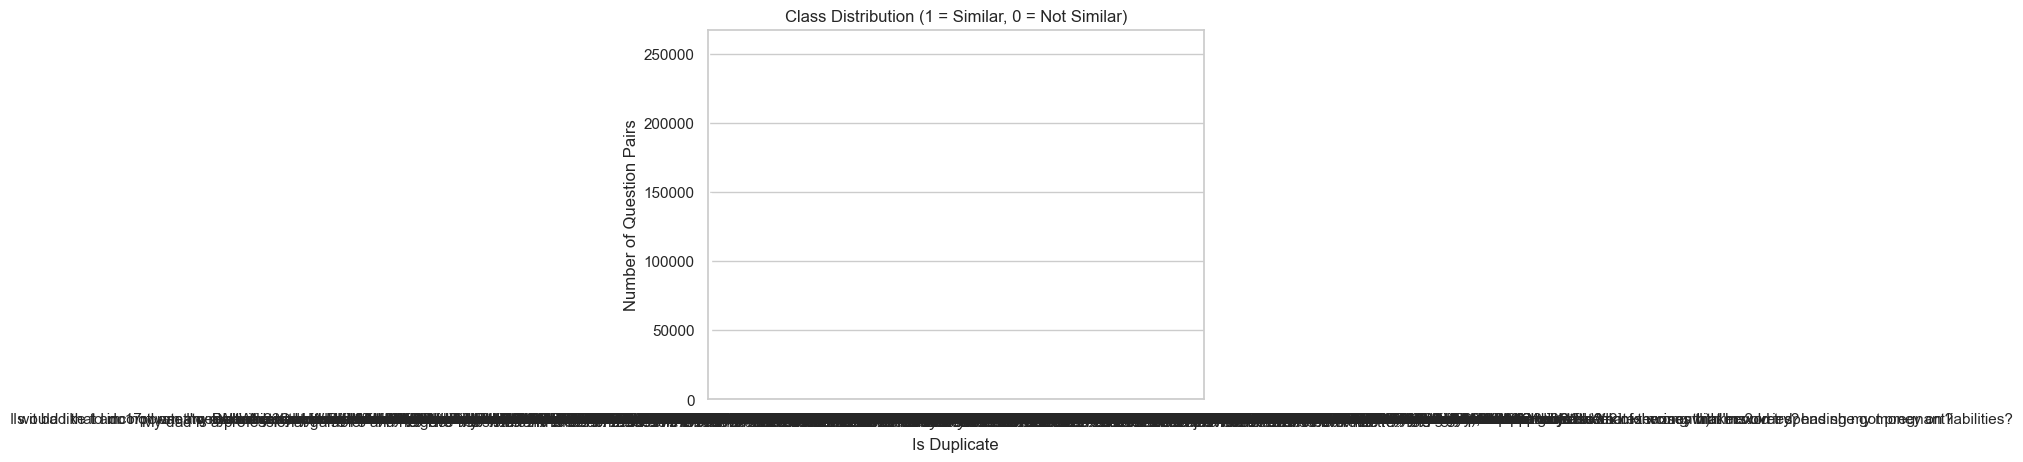

Descriptive statistics of question lengths:
       question1_length  question2_length
count     404348.000000     404348.000000
mean          11.123005         11.367668
std            5.568239          6.475443
min            0.000000          0.000000
25%            7.000000          7.000000
50%           10.000000         10.000000
75%           13.000000         13.000000
max          128.000000        248.000000


In [5]:

df.head()

# Exploratory Data Analysis (EDA)
# checking for missing values
print("Missing values in the dataset:\n", df.isnull().sum())

# class distribution
sns.countplot(x='is_duplicate', data=df)
plt.title("Class Distribution (1 = Similar, 0 = Not Similar)")
plt.xlabel("Is Duplicate")
plt.ylabel("Number of Question Pairs")
plt.show()

# statistics
print("Descriptive statistics of question lengths:")
df['question1_length'] = df['question1'].apply(lambda x: len(str(x).split()))
df['question2_length'] = df['question2'].apply(lambda x: len(str(x).split()))
print(df[['question1_length', 'question2_length']].describe())


Data Splitting

In [8]:
# train-validation split on the entire filtered data without stratifying
train_df, val_df = train_test_split(df, test_size=0.2, random_state=42)

# initial sizes and class distribution
print(f"Initial training set size: {len(train_df)}")
print(f"Initial validation set size: {len(val_df)}")
print("Initial class distribution in training set:")
print(train_df['is_duplicate'].value_counts())
print("Initial class distribution in validation set:")
print(val_df['is_duplicate'].value_counts())

# checking for overlapping question pairs using merge
train_pairs = train_df.assign(pair=train_df['question1'] + '||' + train_df['question2'])
val_pairs = val_df.assign(pair=val_df['question1'] + '||' + val_df['question2'])
overlap = pd.merge(train_pairs, val_pairs, on='pair', how='inner')

has_overlap = not overlap.empty

if has_overlap:
    overlapping_pairs = set(zip(overlap['question1_x'], overlap['question2_x']))
    print(f"Overlapping pairs found: {len(overlapping_pairs)}")
    val_df = val_df[~val_df.set_index(['question1', 'question2']).index.isin(overlapping_pairs)]
    
    if val_df.empty:
        print("Validation set is empty after removing overlaps.")
    else:
        print(f"New validation set size: {len(val_df)}")

# final sizes and distributions
print(f"Final training set size: {len(train_df)}")
print(f"Final validation set size: {len(val_df)}")

print("Final class distribution in training set:")
print(train_df['is_duplicate'].value_counts())
print("Final class distribution in validation set:")
print(val_df['is_duplicate'].value_counts())


Class distribution after filtering:
is_duplicate
0                                                                                                                                                                                 254725
1                                                                                                                                                                                 149267
 he's straight. What should I do?                                                                                                                                                     10
 ?                                                                                                                                                                                     5
What are some TL                                                                                                                                                                       5
                          

: 

Model Selection

In [ ]:
# loading pre-trained BERT model for sequence classification
model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased",
    num_labels=2,
    output_attentions=False,
    output_hidden_states=False
)

# moving model to GPU if available
model.to(device)


Model Training

In [ ]:
from torch.utils.data import DataLoader, TensorDataset, RandomSampler, SequentialSampler
import logging
import random

# logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

# labels to numeric
train_df['is_duplicate'] = pd.to_numeric(train_df['is_duplicate'], errors='coerce')
val_df['is_duplicate'] = pd.to_numeric(val_df['is_duplicate'], errors='coerce')

# NaN values with 0 or any other default value
train_df['is_duplicate'] = train_df['is_duplicate'].fillna(0)
val_df['is_duplicate'] = val_df['is_duplicate'].fillna(0)

# random seeds for reproducibility
random_seed = 42
torch.manual_seed(random_seed)
np.random.seed(random_seed)
random.seed(random_seed)

# tokenizer initialization
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# tokenization
def tokenize_questions(questions1, questions2):
    inputs = tokenizer(
        list(questions1), 
        list(questions2), 
        return_tensors='pt', 
        padding=True, 
        truncation=True,
        max_length=128
    )
    return inputs['input_ids'], inputs['attention_mask']

# tokenizing the training and validation questions
train_inputs, train_masks = tokenize_questions(train_df['question1'].tolist(), train_df['question2'].tolist())
val_inputs, val_masks = tokenize_questions(val_df['question1'].tolist(), val_df['question2'].tolist())

# labels to tensors
train_labels = torch.tensor(train_df['is_duplicate'].values, dtype=torch.long)
val_labels = torch.tensor(val_df['is_duplicate'].values, dtype=torch.long)

# moving tensors to device (CPU or GPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
train_inputs = train_inputs.to(device)
train_masks = train_masks.to(device)
train_labels = train_labels.to(device)
val_inputs = val_inputs.to(device)
val_masks = val_masks.to(device)
val_labels = val_labels.to(device)

# dataloader settings
batch_size = 16
epochs = 100

# tensorDatasets
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

val_data = TensorDataset(val_inputs, val_masks, val_labels)
val_sampler = SequentialSampler(val_data)
val_dataloader = DataLoader(val_data, sampler=val_sampler, batch_size=batch_size)

# optimizer and learning rate scheduler setup
optimizer = AdamW(model.parameters(), lr=2e-5, eps=1e-8)  # Use PyTorch's AdamW
total_steps = len(train_dataloader) * epochs  # total training steps
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)

# training
training_loss_values = []
validation_loss_values = []
best_val_loss = float('inf')
patience = 80  # epochs to wait before stopping
patience_counter = 0  # counter for early stopping

for epoch in range(epochs):
    logging.info(f"Epoch {epoch + 1}/{epochs}")
    
    # training phase
    model.train()
    total_loss = 0
    
    for batch in train_dataloader:
        b_input_ids, b_input_mask, b_labels = tuple(t.to(device) for t in batch)
        
        model.zero_grad()
        outputs = model(b_input_ids, attention_mask=b_input_mask, labels=b_labels)
        loss = outputs.loss
        total_loss += loss.item()
        
        loss.backward()
        optimizer.step()
        scheduler.step()
    
    avg_train_loss = total_loss / len(train_dataloader)
    training_loss_values.append(avg_train_loss)
    logging.info(f"Average training loss: {avg_train_loss:.2f}")

    # validation phase
    model.eval()
    total_val_loss = 0
    
    with torch.no_grad():
        for batch in val_dataloader:
            b_input_ids, b_input_mask, b_labels = tuple(t.to(device) for t in batch)
            outputs = model(b_input_ids, attention_mask=b_input_mask, labels=b_labels)
            val_loss = outputs.loss
            total_val_loss += val_loss.item()
    
    avg_val_loss = total_val_loss / len(val_dataloader)
    validation_loss_values.append(avg_val_loss)
    logging.info(f"Validation loss: {avg_val_loss:.2f}")
    
    # early stopping logic
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        patience_counter = 0
        torch.save(model.state_dict(), 'best_model.pth')
    else:
        patience_counter += 1
        if patience_counter >= patience:
            logging.info(f"Early stopping at epoch {epoch + 1}.")
            break

Model Evaluation

In [ ]:

predictions, true_labels, original_indices = [], [], []

# evaluation function
def evaluate(model, dataloader):
    model.eval()
    
    for batch in dataloader:
        b_input_ids, b_input_mask, b_labels = tuple(t.to(device) for t in batch)
        
        with torch.no_grad():
            outputs = model(b_input_ids, attention_mask=b_input_mask)
            logits = outputs.logits
        
        # collecting original indices (dataloader should maintain the order)
        original_indices.extend(batch[0].cpu().numpy())  # the first item in the batch corresponds to the original indices
        predictions.extend(torch.argmax(logits, dim=1).cpu().numpy())
        true_labels.extend(b_labels.cpu().numpy())
    
    # calculating metrics
    accuracy = accuracy_score(true_labels, predictions)
    precision = precision_score(true_labels, predictions)
    recall = recall_score(true_labels, predictions)
    f1 = f1_score(true_labels, predictions)
    
    # calculating ROC-AUC score
    roc_auc = roc_auc_score(true_labels, [logit[1] for logit in logits.cpu().numpy()])  # Assuming binary classification
    
    # error analysis
    misclassified_indices = [i for i, (true, pred) in enumerate(zip(true_labels, predictions)) if true != pred]
    misclassified_examples = [(original_indices[i], true_labels[i], predictions[i]) for i in misclassified_indices]
    
    return accuracy, precision, recall, f1, roc_auc, misclassified_examples

# evaluating on validation set
val_accuracy, val_precision, val_recall, val_f1, val_roc_auc, misclassified_examples = evaluate(model, val_dataloader)
print(f"Validation Accuracy: {val_accuracy:.2f}")
print(f"Validation Precision: {val_precision:.2f}")
print(f"Validation Recall: {val_recall:.2f}")
print(f"Validation F1 Score: {val_f1:.2f}")
print(f"Validation ROC-AUC: {val_roc_auc:.2f}")

# misclassified examples (original index, true label, predicted label)
for idx, true_label, pred_label in misclassified_examples:
    print(f"Misclassified Example - Index: {idx}, True Label: {true_label}, Predicted Label: {pred_label}")


Error Analysis

In [ ]:
# confusion matrix
conf_matrix = confusion_matrix(true_labels, predictions)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

# displaying some misclassified examples
misclassified_idx = [i for i, (pred, true) in enumerate(zip(predictions, true_labels)) if pred != true]
for idx in misclassified_idx[:5]:
    q1 = val_df.iloc[idx]['question1']
    q2 = val_df.iloc[idx]['question2']
    print(f"Q1: {q1}\nQ2: {q2}\nPredicted: {predictions[idx]}, Actual: {true_labels[idx]}\n")


Hyperparameter Optimization

In [ ]:
import optuna
from sklearn.metrics import f1_score

# objective function for Optuna
def objective(trial):
    # hyperparameters to tune
    learning_rate = trial.suggest_loguniform('learning_rate', 1e-6, 1e-4)
    batch_size = trial.suggest_categorical('batch_size', [8, 16, 32])
    epochs = trial.suggest_int('epochs', 2, 5)
    warmup_steps = trial.suggest_int('warmup_steps', 0, 100)
    dropout_rate = trial.suggest_float('dropout_rate', 0.1, 0.5)
    weight_decay = trial.suggest_loguniform('weight_decay', 1e-5, 1e-2)
    
    # a smaller subset of the training data for the trials
    small_train_data = train_data[:int(len(train_data) * 0.1)]  # 10% of the original data
    small_val_data = val_data[:int(len(val_data) * 0.1)]  # 10% of the original validation data

    # dataloader setup with trial batch size
    train_dataloader = DataLoader(small_train_data, sampler=train_sampler, batch_size=batch_size)
    val_dataloader = DataLoader(small_val_data, sampler=val_sampler, batch_size=batch_size)
    
    # model setup
    model = BertForSequenceClassification.from_pretrained(
        "bert-base-uncased",
        num_labels=2,
        output_attentions=False,
        output_hidden_states=False
    ).to(device)
    
    # applying dropout in model if necessary (custom model modification may be required)
    model.dropout.p = dropout_rate  # dropout rate setting (this assumes you have a model that allows setting dropout rate)

    optimizer = AdamW(model.parameters(), lr=learning_rate, eps=1e-8, weight_decay=weight_decay)
    total_steps = len(train_dataloader) * epochs
    scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=warmup_steps, num_training_steps=total_steps)
    
    # training loop with early stopping
    best_f1 = 0
    patience = 2
    patience_counter = 0

    model.train()
    for epoch in range(epochs):
        total_loss = 0
        for batch in train_dataloader:
            b_input_ids, b_input_mask, b_labels = tuple(t.to(device) for t in batch)
            model.zero_grad()
            outputs = model(b_input_ids, attention_mask=b_input_mask, labels=b_labels)
            loss = outputs.loss
            total_loss += loss.item()
            loss.backward()
            optimizer.step()
            scheduler.step()

        # validation
        accuracy, precision, recall, f1 = evaluate(model, val_dataloader)
        print(f"Epoch {epoch + 1}/{epochs} - F1 Score: {f1:.4f}")
        
        # checking for early stopping
        if f1 > best_f1:
            best_f1 = f1
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print("Early stopping triggered")
                break

    return best_f1  # objective: maximize F1 score

# running the Optuna optimization
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=10)

print(f"Best hyperparameters: {study.best_params}")


Testing on Unseen Data

In [ ]:

test_data_path = 'q_quora_test.csv'  # from a separate dataset
test_df = pd.read_csv(test_data_path, usecols=['id', 'qid1', 'qid2', 'question1', 'question2'])

# cleaning and preprocessing the test data
test_df.dropna(subset=['question1', 'question2'], inplace=True)
test_df['question1'] = test_df['question1'].apply(clean_text)
test_df['question2'] = test_df['question2'].apply(clean_text)

test_inputs, test_masks, test_labels = create_dataset(test_df)

# dataloader for the test set
test_data = TensorDataset(test_inputs, test_masks, test_labels)
test_sampler = SequentialSampler(test_data)
test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=16)

# evaluating the test set
test_accuracy, test_precision, test_recall, test_f1 = evaluate(model, test_dataloader)
print(f"Test Accuracy: {test_accuracy:.2f}")
print(f"Test Precision: {test_precision:.2f}")
print(f"Test Recall: {test_recall:.2f}")
print(f"Test F1 Score: {test_f1:.2f}")


Visualization of Results

In [ ]:
from sklearn.metrics import roc_curve, auc

# plotting training vs. validation Loss
plt.plot(training_loss_values, label="Training Loss")
plt.plot(validation_loss_values, label="Validation Loss")
plt.title("Training vs. Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

# ROC curve

def evaluate(model, dataloader):
    model.eval()
    predictions = []
    true_labels = []
    with torch.no_grad():
        for batch in dataloader:
            b_input_ids, b_input_mask, b_labels = tuple(t.to(device) for t in batch)
            outputs = model(b_input_ids, attention_mask=b_input_mask)
            logits = outputs.logits  # the raw logits
            predictions.extend(logits.softmax(dim=1).cpu().numpy())  # logits to probabilities
            true_labels.extend(b_labels.cpu().numpy())
    
    return true_labels, predictions

true_labels, predictions = evaluate(model, test_dataloader)
fpr, tpr, _ = roc_curve(true_labels, predictions[:, 1])  # probabilities for the positive class
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.title('Receiver Operating Characteristic')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.show()

